LATAM           51594
Europe          50252
Pacific Asia    41260
USCA            25799
Africa          11614
Name: Market, dtype: int64

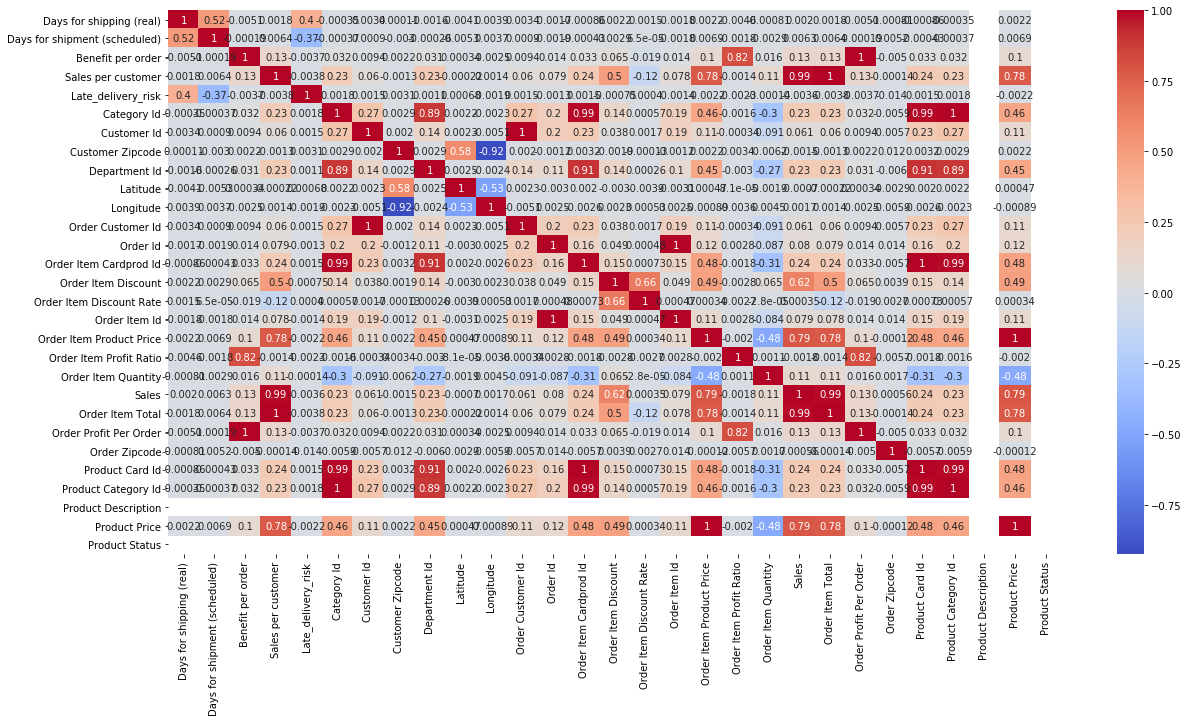

In [1]:
import pandas as pd

# 数据加载
dataset = pd.read_csv('./SupplyChain.csv', encoding = 'unicode_escape')

# 缺失值个数求和
dataset.isnull().sum()

# 画热力图
import matplotlib.pyplot as plt
import seaborn as sns
data = dataset
plt.figure(figsize = (20,10))
sns.heatmap(data.corr(), annot = True, cmap = 'coolwarm')

data['Market'].value_counts()


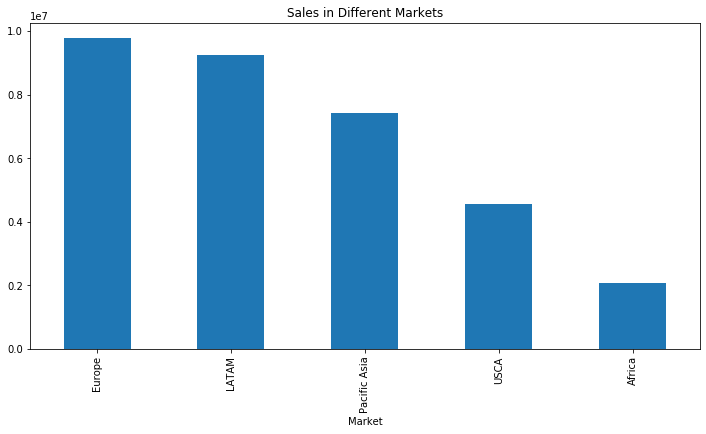

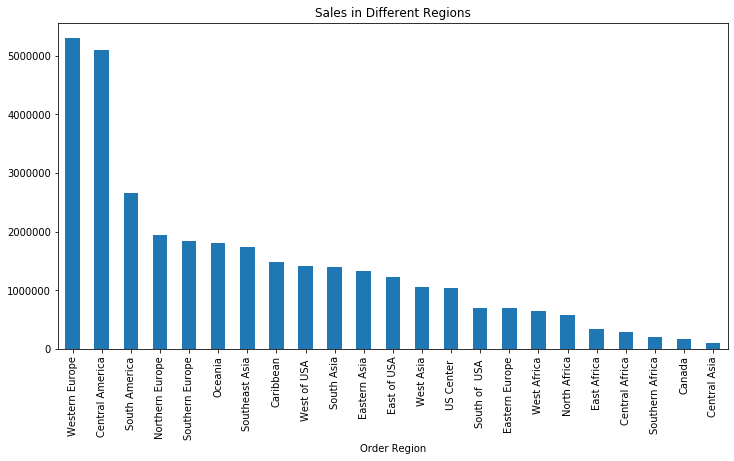

In [2]:
# 按照不同的Market，Order Region
market = data.groupby('Market')
plt.figure(1)
market['Sales per customer'].sum().sort_values(ascending = False).plot.bar(figsize = (12,6), title='Sales in Different Markets')

market = data.groupby('Order Region')
plt.figure(2)
market['Sales per customer'].sum().sort_values(ascending = False).plot.bar(figsize = (12,6), title='Sales in Different Regions')

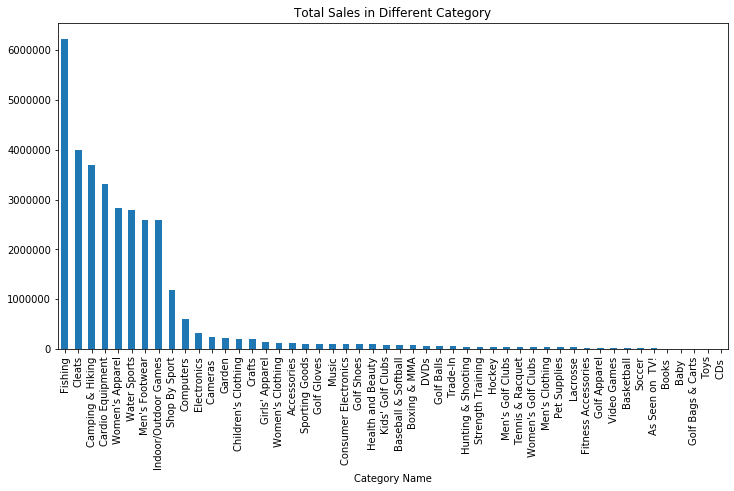

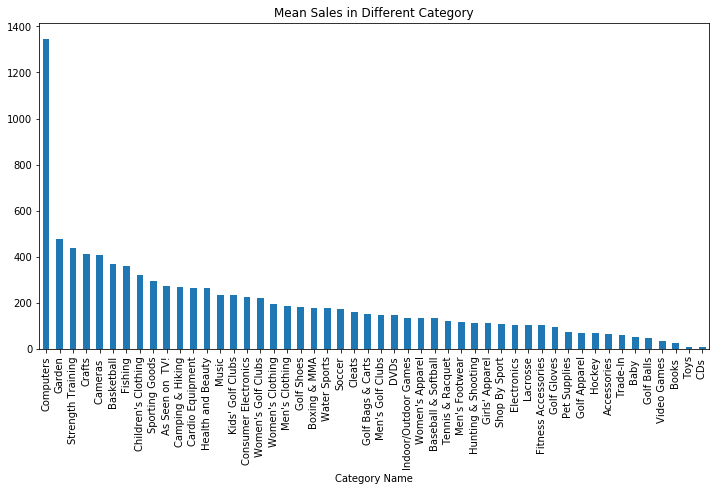

In [3]:
# 按照不同的Category Name
cat = data.groupby('Category Name')
# 使用SUM计算每个分类的总金额
plt.figure(1)
cat['Sales per customer'].sum().sort_values(ascending = False).plot.bar(figsize = (12,6), title='Total Sales in Different Category')
# 使用SUM计算每个分类的总金额
plt.figure(2)
cat['Sales per customer'].mean().sort_values(ascending = False).plot.bar(figsize = (12,6), title='Mean Sales in Different Category')

In [4]:
# 按照不同的时间维度（年/月/星期/小时）的趋势
temp = pd.DatetimeIndex(data['order date (DateOrders)'])
# temp

# 取order date (DateOrders)字段中的year，month, weekday, hour, month_year
data['order_year'] = temp.year
data['order_month'] = temp.month
data['order_week_day'] = temp.weekday
data['order_hour'] = temp.hour
data['order_month_year'] = temp.to_period('M')
data[['order date (DateOrders)', 'order_year', 'order_month', 'order_week_day']]

,order date (DateOrders),order_year,order_month,order_week_day
0,1/31/2018 22:56,2018,1,2
1,1/13/2018 12:27,2018,1,5
2,1/13/2018 12:06,2018,1,5
3,1/13/2018 11:45,2018,1,5
4,1/13/2018 11:24,2018,1,5
...,...,...,...,...
180514,1/16/2016 3:40,2016,1,5
180515,1/16/2016 1:34,2016,1,5
180516,1/15/2016 21:00,2016,1,4
180517,1/15/2016 20:18,2016,1,4


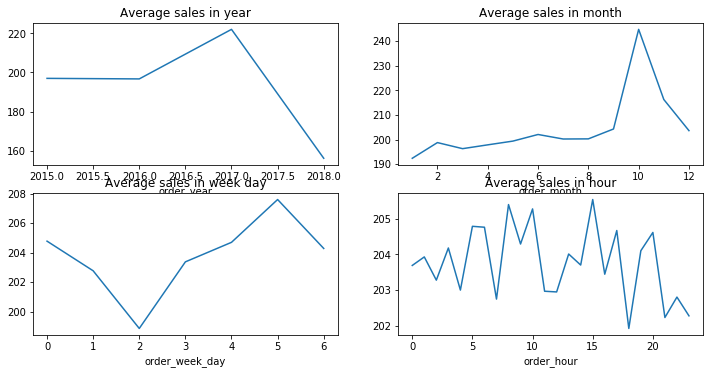

In [5]:
# 按照不同的时间维度（年/月/星期/小时）的趋势
plt.figure(figsize = (10,12))
plt.subplot(4, 2, 1)
df_year = data.groupby('order_year')
df_year['Sales'].mean().plot(figsize =(12,12), title = 'Average sales in year' )
# df_year['Sales'].sum().plot(figsize =(12,12), title = 'Total sales in year' )

plt.subplot(4, 2, 2)
df_month = data.groupby('order_month')
df_month['Sales'].mean().plot(figsize =(12,12), title = 'Average sales in month' )

plt.subplot(4, 2, 3)
df_week_day = data.groupby('order_week_day')
df_week_day['Sales'].mean().plot(figsize =(12,12), title = 'Average sales in week day' )

plt.subplot(4, 2, 4)
df_hour = data.groupby('order_hour')
df_hour['Sales'].mean().plot(figsize =(12,12), title = 'Average sales in hour' )


## 用户分层 RFM

In [6]:
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'])
# data['order date (DateOrders)']
# 统计最后一笔订单的时间
data['order date (DateOrders)'].max()

Timestamp('2018-01-31 23:38:00')

In [7]:
# 假设现在是2018-02-01
import datetime
present = datetime.datetime(2018,2,1)
# 计算每个用户的RFM指标
data['Order Customer Id'].value_counts()

data['TotalPrice'] = data['Order Item Quantity'] * data['Order Item Product Price']
data[['TotalPrice', 'Order Item Quantity', 'Order Item Product Price', 'Order Item Total']]

customer_seg = data.groupby('Order Customer Id').agg({'order date (DateOrders)': lambda x: (present-x.max()).days, 
                                                      'Order Id': lambda x: len(x), 
                                                      'Order Item Total': lambda x: sum(x)})
customer_seg

# 将字段名称改成 R/F/M
customer_seg.rename(columns = {'order date (DateOrders)': 'R_Value', 
                               'Order Id': 'F_Value', 'Order Item Total': 'M_Value'}, inplace = True)
customer_seg

,R_Value,F_Value,M_Value
Order Customer Id,,,
1,792,1,472.450012
2,136,10,1618.660042
3,229,18,3189.200037
4,380,14,1480.709993
5,457,7,1101.919998
...,...,...,...
20753,0,1,161.869995
20754,0,1,172.660004
20755,0,1,314.640015


In [8]:
# 比如划分为4个等级1-4，4为最高等级
quantiles = customer_seg.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()
quantiles

# R_Value 越小越好 => R_Score 就越大
# apply前面的是参数a
def R_Score(a, b, c):
    if a<c[b][0.25]:
        return 4
    if a<c[b][0.50]:
        return 3
    if a<c[b][0.75]:
        return 2
    return 1

# F_Value，M_Value 越大越好
def FM_Score(a, b, c):
    if a<c[b][0.25]:
        return 1
    if a<c[b][0.50]:
        return 2
    if a<c[b][0.75]:
        return 3
    return 4

# 新字段R_Score, 用于将R_Value => [1,4]
customer_seg['R_Score'] = customer_seg['R_Value'].apply(R_Score, args=('R_Value', quantiles))
# 新字段F_Score, 用于将F_Value => [1,4]
customer_seg['F_Score'] = customer_seg['F_Value'].apply(FM_Score, args=('F_Value', quantiles))
# 新字段M_Score, 用于将M_Value => [1,4]
customer_seg['M_Score'] = customer_seg['M_Value'].apply(FM_Score, args=('M_Value', quantiles))
customer_seg

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score
Order Customer Id,,,,,,
1,792,1,472.450012,1,2,2
2,136,10,1618.660042,3,3,3
3,229,18,3189.200037,2,4,4
4,380,14,1480.709993,1,3,3
5,457,7,1101.919998,1,3,2
...,...,...,...,...,...,...
20753,0,1,161.869995,4,2,1
20754,0,1,172.660004,4,2,1
20755,0,1,314.640015,4,2,2


In [9]:
# 计算用户RFM分层
def RFM_User(df):
    if df['M_Score'] > 2 and df['F_Score'] > 2 and df['R_Score'] > 2:
        return '重要价值用户'
    if df['M_Score'] > 2 and df['F_Score'] <= 2 and df['R_Score'] > 2:
        return '重要发展用户'
    if df['M_Score'] > 2 and df['F_Score'] > 2 and df['R_Score'] <= 2:
        return '重要保持用户'
    if df['M_Score'] > 2 and df['F_Score'] <= 2 and df['R_Score'] <= 2:
        return '重要挽留用户'
    if df['M_Score'] <= 2 and df['F_Score'] > 2 and df['R_Score'] > 2:
        return '一般价值用户'
    if df['M_Score'] <= 2 and df['F_Score'] <= 2 and df['R_Score'] > 2:
        return '一般发展用户'
    if df['M_Score'] <= 2 and df['F_Score'] > 2 and df['R_Score'] <= 2:
        return '一般保持用户'
    if df['M_Score'] <= 2 and df['F_Score'] <= 2 and df['R_Score'] <= 2:
        return '一般挽留用户'
    
customer_seg['Customer_Segmentation'] = customer_seg.apply(RFM_User, axis=1)
customer_seg

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,Customer_Segmentation
Order Customer Id,,,,,,,
1,792,1,472.450012,1,2,2,一般挽留用户
2,136,10,1618.660042,3,3,3,重要价值用户
3,229,18,3189.200037,2,4,4,重要保持用户
4,380,14,1480.709993,1,3,3,重要保持用户
5,457,7,1101.919998,1,3,2,一般保持用户
...,...,...,...,...,...,...,...
20753,0,1,161.869995,4,2,1,一般发展用户
20754,0,1,172.660004,4,2,1,一般发展用户
20755,0,1,314.640015,4,2,2,一般发展用户


In [10]:
customer_seg['Customer_Segmentation'].value_counts()

一般发展用户    8141
重要保持用户    8105
重要价值用户    1814
一般挽留用户    1533
一般保持用户     597
重要发展用户     304
重要挽留用户     103
一般价值用户      55
Name: Customer_Segmentation, dtype: int64